In [1]:
%run -i setup

c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))

IPython CPU timings (estimated):
  User   :     102.09 s.
  System :       0.00 s.
Wall time:     102.09 s.


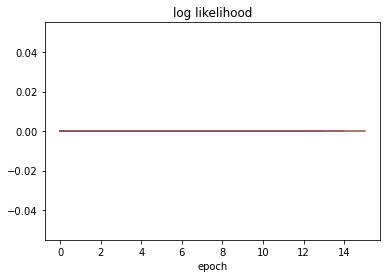

In [2]:
%run -i -t train

(2680, 100)


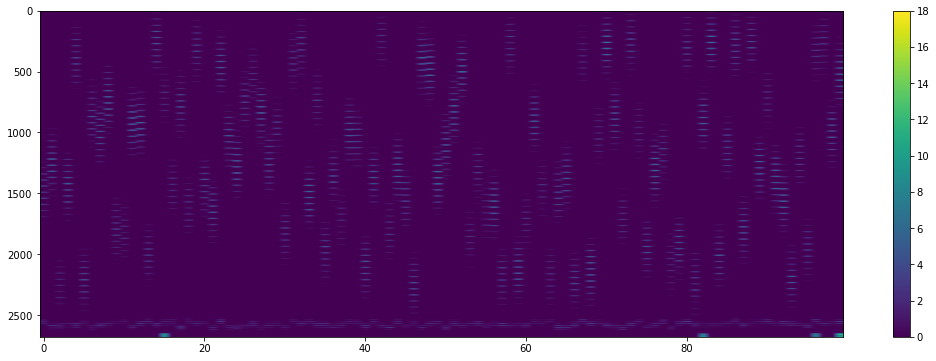

In [3]:
plt.figure(5,figsize=(18,6))
plt.imshow(stims,aspect='auto')
plt.colorbar()
print(stims.shape)

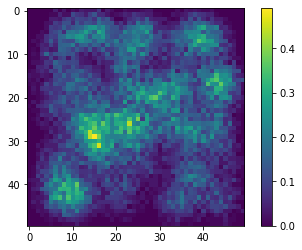

In [4]:
""" for i in range(100):
        pH=np.multiply(g.NeuronInfo[1].min+(g.NeuronInfo[1].max-g.NeuronInfo[1].min),*np.random.rand(1,2))
        if np.random.rand()>pCouple:
            pBc=g.NeuronInfo[0].min-.15+ np.multiply((.3+g.NeuronInfo[0].max-g.NeuronInfo[0].min),*np.random.rand(1,2))
        else:
            pBc=pH+.15*np.random.normal(1,2)
        gains=4+6*np.random.rand(3,1)
        Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
        stims[:,i]=np.concatenate((Bc, H, T), axis=None)
plt.imshow(np.random.poisson(lam=np.mean(stims[:2500,:],axis=1).reshape(50,50)))
plt.colorbar() """
plt.imshow(np.mean(stims[:2500,:],axis=1).reshape(50,50))
#plt.imshow(np.mean(stims[2650:2680,:],axis=1).reshape(10,3))
plt.colorbar()

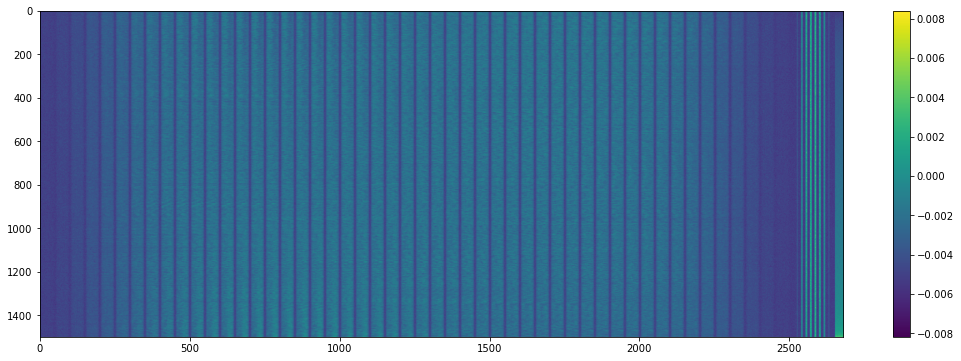

In [5]:
plt.figure(1,figsize=(18,6))
plt.imshow(g.WUp[0].W,aspect='auto')
plt.colorbar()

<Figure size 432x288 with 0 Axes>

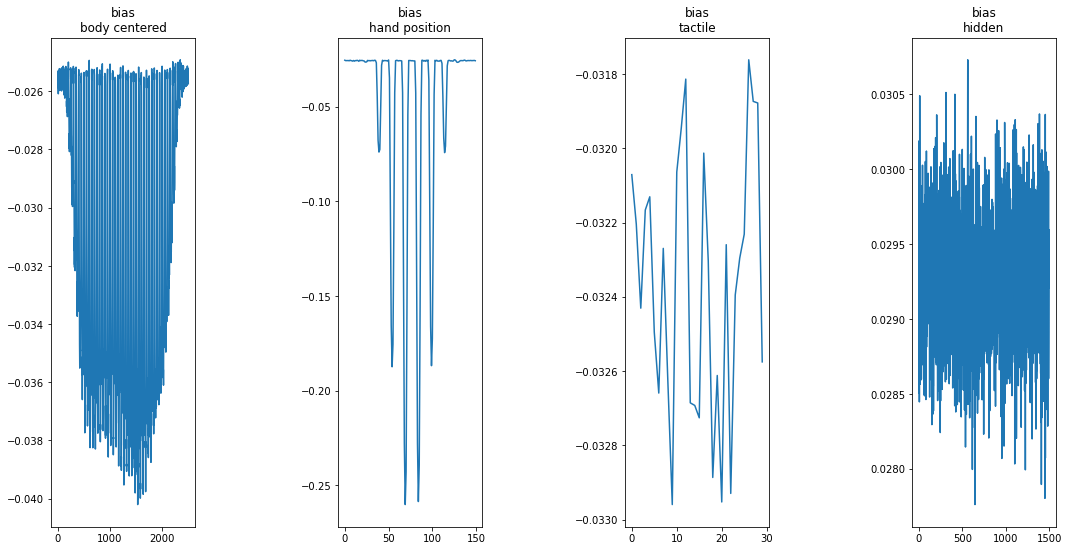

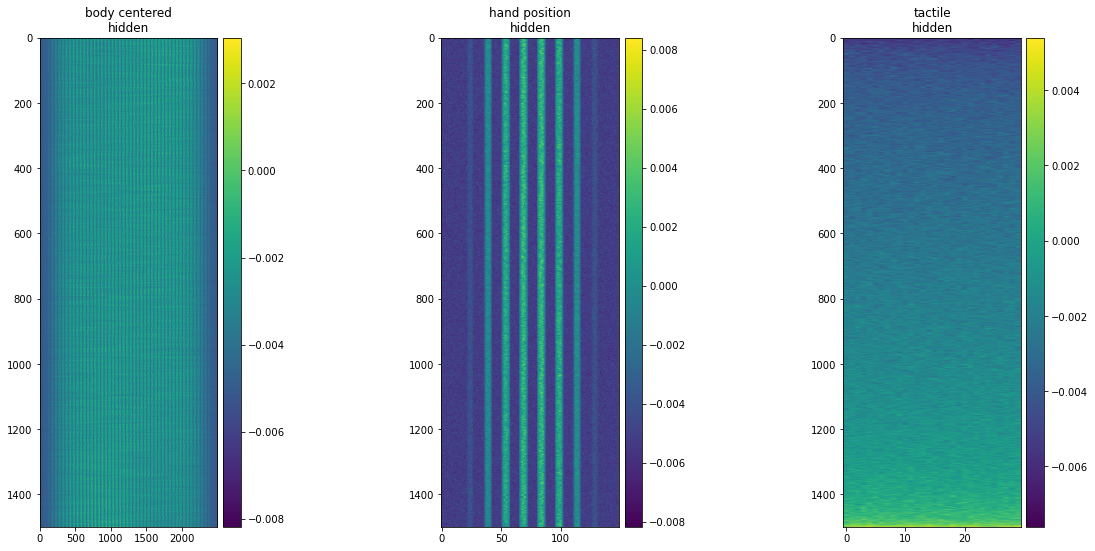

In [6]:
myw,myor = g.showPars(True)

In [7]:
## hand centered vs body centered tactile evoked activity
ntrials=10000
N_vects=100
ntrials=int(np.round(ntrials/N_vects)*N_vects)

nsteps=1
pBcs=np.zeros((ntrials,2))
pHs=np.zeros((ntrials,2))
pHcs=np.zeros((ntrials,2))
Ts=np.zeros(ntrials)
nGridPoints=17
stims=np.zeros((np.sum(g.NV),N_vects),dtype=float)
count=0
w=g.allW()
bh=g.allBh()
bv=g.allBv()
for i in np.arange( int(np.round(ntrials/N_vects)) ):
    if (i%10)==0:print(i)
    
    for v in np.arange(N_vects):
        count=count+1
        #pBc=g.NeuronInfo[0].min+np.multiply(g.NeuronInfo[0].max-g.NeuronInfo[0].min,*np.random.rand(1,2))
        pBc=g.NeuronInfo[0].min+np.multiply(g.NeuronInfo[0].max-g.NeuronInfo[0].min,np.random.rand(2))
        #pH=g.NeuronInfo[1].min+np.multiply(g.NeuronInfo[1].max-g.NeuronInfo[1].min,*np.random.rand(1,2))
        pH=g.NeuronInfo[1].min+np.multiply(g.NeuronInfo[1].max-g.NeuronInfo[1].min,np.random.rand(2))
        #gains=4+6*np.random.rand(3,1)
        gains=4+6*np.random.rand(3)
        Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
        T=0*T
        stims[:,v]=np.concatenate((Bc, H, T), axis=None)
        pBcs[count-1,:]=pBc
        pHs[count-1,:]=pH
        pHcs[count-1,:]=pBc-pH
    
    v=stims
    for s in np.arange(nsteps):
        #noiseless up and down passes, since we only care about averages
        #for the plots
        #up
        gv=w@v+bh
        mu=1.0/(1.0+np.exp(-gv))
        mu=mu.conj().T
        h=mu.conj().T
        #down
        gv=w.conj().T@h+bv
        mu=np.exp(gv)
        v=mu
        v[:-g.NV[2],:]=stims[:-g.NV[2],:]
        
    Ts[(i)*N_vects:(i+1)*N_vects] = np.nanmean(v[-g.NV[2]:,:],axis=0) 

0
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
10
20
30
40
50
60
70
80
90


In [13]:
## TODO explore pBcs stuff. Check posToInd and stimgen meshgrid. Get intuition about neuron units and meters> model structure.
## Beware indexing and neuron numbering. Beware elambda.
#print(etas)
#CHECK IF pos[0] and pBc corresponds to xg in my implementation. 

In [9]:
def bindata2d(x,y,z,nbins):
    #https://stackoverflow.com/questions/55874812/what-is-a-joint-histogram-and-a-marginal-histogram-in-image-processing
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html#scipy.stats.binned_statistic_2d

    Xedges=np.linspace(np.min(x),np.max(x),nbins+1)
    Yedges=np.linspace(np.min(y),np.max(y),nbins+1)

    xc=(Xedges[:-1]+Xedges[1:])/2
    yc=(Yedges[:-1]+Yedges[1:])/2

    ret = stats.binned_statistic_2d(x,y,None,statistic='count',bins=[Xedges,Yedges],expand_binnumbers=True)
    indX=ret.binnumber[0,:]
    indY=ret.binnumber[1,:]

    grid=np.zeros((nbins,nbins))
    stds=np.zeros((nbins,nbins)) # TODO explore if stds and ns are relevant and behave as expected. 
    ns=np.zeros((nbins,nbins))

    for i in np.arange(nbins):
        for j in np.arange(nbins):
            grid[i,j]=np.nanmean( z [np.where((indX==(j+1))*(indY==(i+1)))] ) 
            #grid[i,j]=np.nanmean( z [np.where((indX==(j))*(indY==(i)))] )
            stds[i,j]=np.nanstd(z[ np.where((indX==(j+1))*(indY==(i+1))) ])
            #stds[i,j]=np.nanstd(z[ np.where((indX==(j))*(indY==(i))) ])
            ns[i,j]=np.sum(~np.isnan(z[ np.where((indX==(j+1))*(indY==(i+1))) ]))
            #ns[i,j]=np.sum(~np.isnan(z[ np.where((indX==(j))*(indY==(i))) ]))

    return grid,xc,yc,stds,ns


def bindata(x, y, numbins, type='mean', q1=0.02, q2=0.98, bins=None):
    #https://stackoverflow.com/questions/51407329/nargin-functionality-from-matlab-in-python
    #BINDATA: function [mu, bins] = bindata(x, y,numbins, type, q1, q2,bins)
    # bins the data y according to x and returns the bins and the MEAN or
    # MEDIAN value of y for that bin
    #INPUT:
    #x: x data vector
    #y: y data vector
    #numbins: number of bins
    ##type: string#: median, mean or mode, default: mean
    #q1: lower quantile of data to remove, default: 0.02
    #q2: upper quantile of data to remove, default: 0.98
    #bins: bins can be provided, in this case numbins, q1, q2 will be ignored
    #OUTPUT:
    #mu: result by bin
    #centers: centers of bins

#distances_main=distances[(distances<np.percentile(distances,98))&(distances>np.percentile(distances,2))]
#hist, bins = np.histogram(distances_main, bins=20)
#center = (bins[:-1] + bins[1:]) / 2

    medianFlag=0
    modeFlag=0

    if (type=='mean'):
        medianFlag=0
    elif (type=='median'):
        medianFlag=1
    elif (type=='mode'):
        modeFlag=1
    else:
        print('unrecognized statistical function')

    minn=np.quantile(x,q1)
    maxx=np.quantile(x,q2)

    mu = np.zeros(numbins)
    stds = np.zeros(numbins)
    sems = np.zeros(numbins)
    centers = np.zeros(numbins)

    if (bins==None):
        bins = np.linspace(minn, maxx, numbins+1)
        n,_,bin = stats.binned_statistic(x,None,statistic='count',bins=bins) #  [n,bin] = histc(x, bins)
        
        for k in np.arange(numbins):
            ind = np.where(bin==k) #find(bin==k)
            if (~np.all(ind==0)): # ~isempty(ind)
                if medianFlag:
                    mu[k] = np.nanmedian(y[ind])
                elif modeFlag:
                    mu[k] = stats.mode(y[ind])
                else:
                    mu[k] = np.nanmean(y[ind])
                
                stds[k] = np.nanstd(y[ind])
                sems[k] = np.nanstd(y[ind])/np.sqrt(np.sum(~np.isnan(y[ind])))
            else:
                mu[k]=NaN
                stds[k] = NaN
                sems[k] = NaN
    
            centers[k]=bins[k]*0.5+bins[k+1]*0.5
        
    else:
        n,_,bin = stats.binned_statistic(x,None,statistic='count',bins=bins) #[n,bin] = histc(x, bins)

        for k in np.arange(np.size(bins)): # 1:numel(bins)-1
            ind = np.where(bin==k)
            if (~np.all(ind==0)):
                ind
                if medianFlag:
                    mu[k] = np.nanmedian(y[ind])
                elif modeFlag:
                    mu[k] = stats.mode(y[ind])
                else:
                    mu[k] = np.nanmean(y[ind])
                
                stds[k] = np.nanstd(y[ind])
                sems[k] = np.nanstd(y[ind])/np.sqrt(np.sum(~np.isnan(y[ind])))
            else:
                mu[k]=NaN
                stds[k] = NaN
                sems[k] = NaN
    
            centers[k]=bins[k]*0.5+bins[k+1]*0.5
        
    
    return centers, mu, stds, sems

train.py:21: RuntimeWarning: Mean of empty slice
  #pBc=g.NeuronInfo[0].min-.15+ np.multiply((.3+g.NeuronInfo[0].max-g.NeuronInfo[0].min),*np.random.rand(1,2))
C:\Users\renat\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<Figure size 432x288 with 0 Axes>

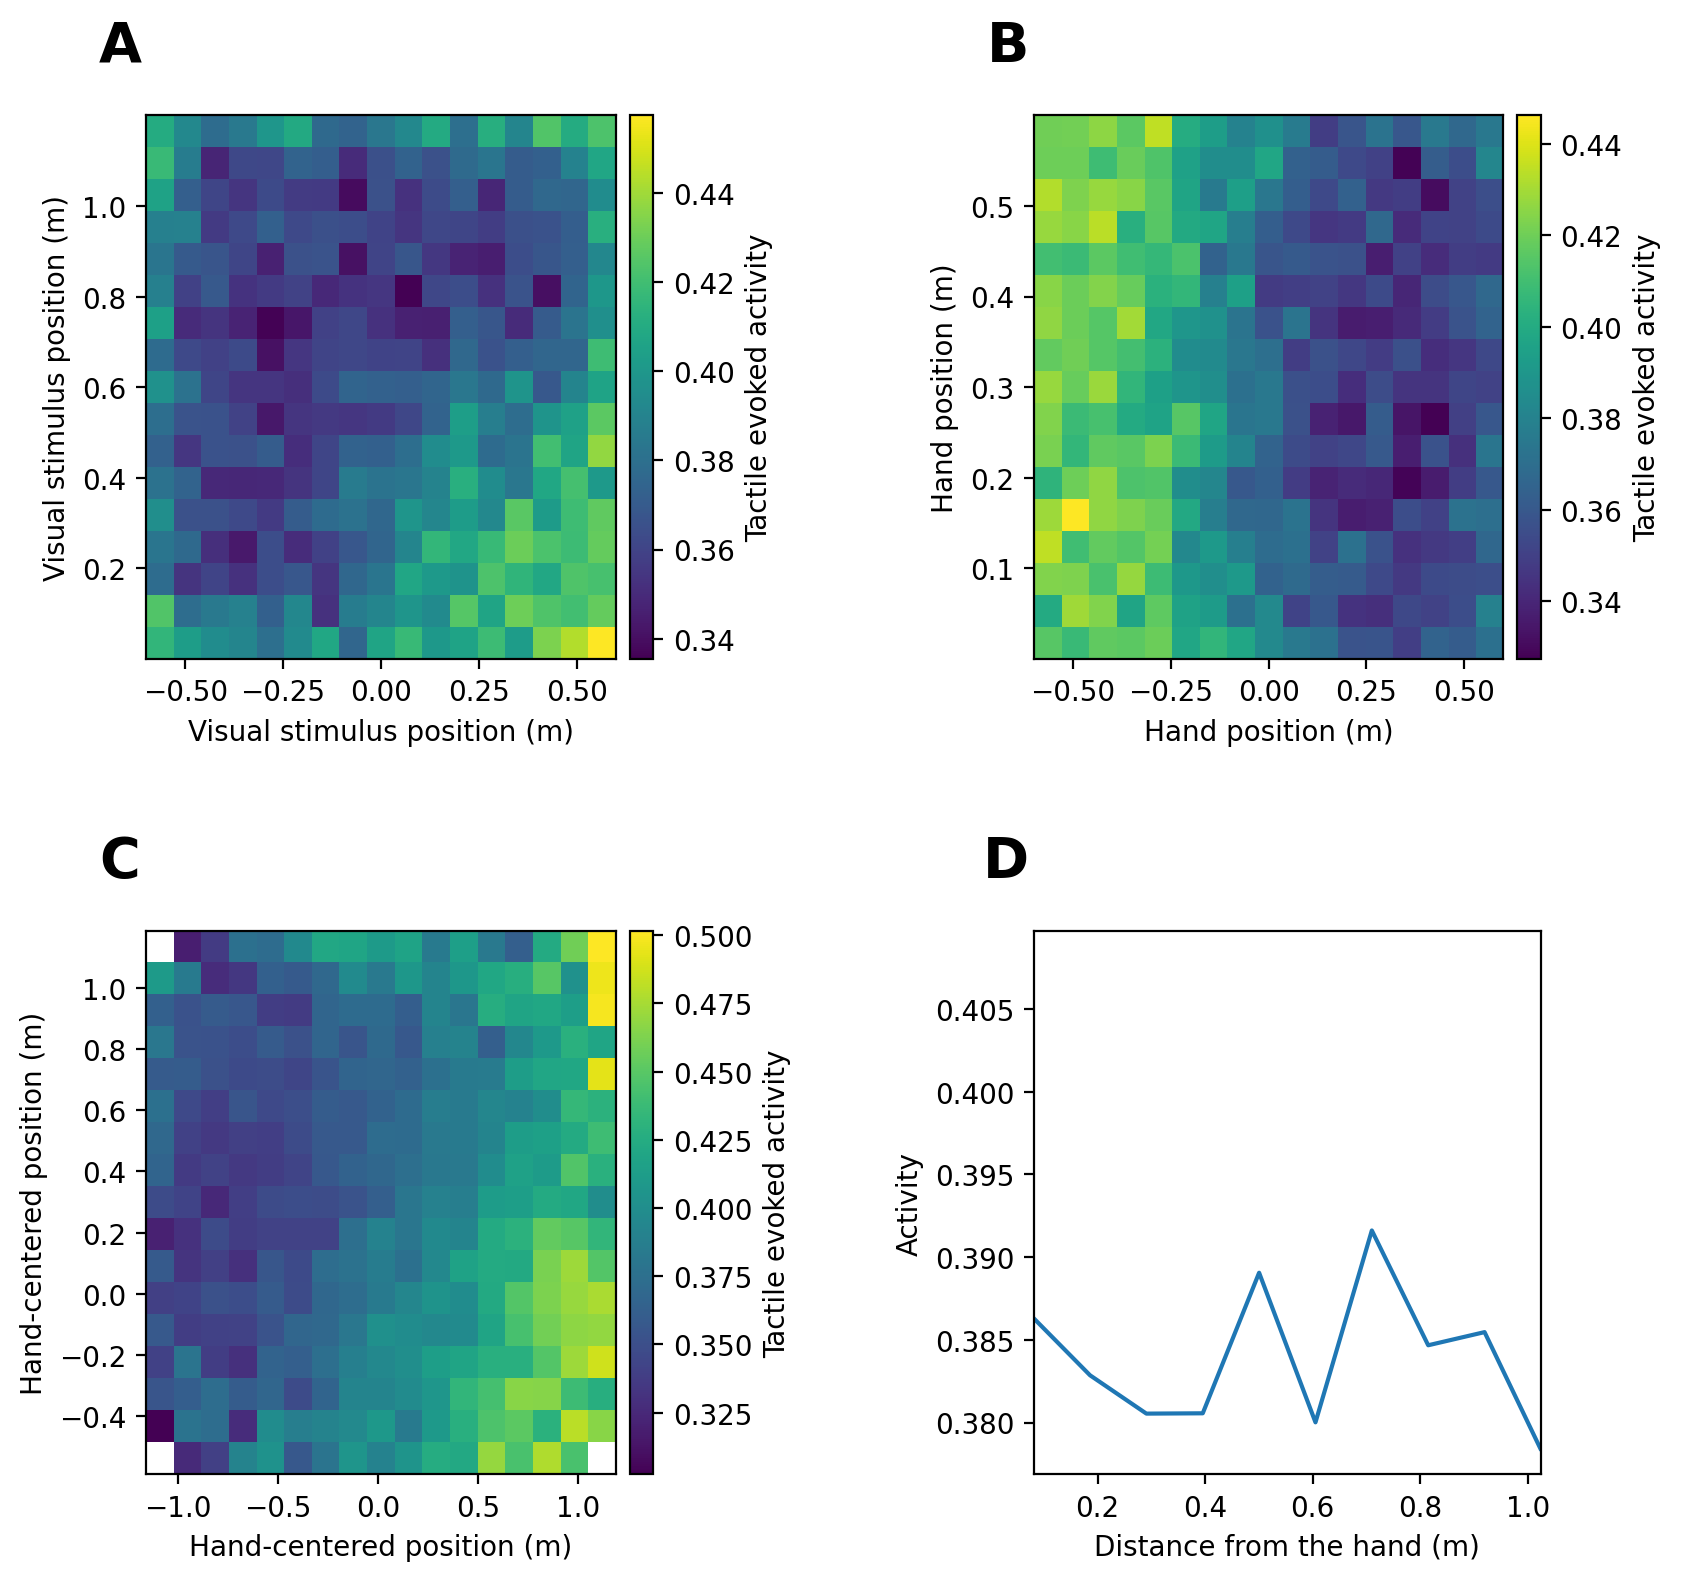

In [10]:
import string
import matplotlib as mpl

def extents(f):
# https://gist.github.com/fasiha/eff0763ca25777ec849ffead370dc907
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

plt.figure(3)

fig, axs = plt.subplots(2, 2, figsize=(9, 9),dpi = 200)
ax1 = plt.subplot(221)
grid,xc,yc,_,_=bindata2d(pBcs[:,0],pBcs[:,1],Ts,nGridPoints)
im1=ax1.imshow(grid, aspect='auto', interpolation='none',
           extent=extents(xc) + extents(yc), origin='lower')
ax1.set_xlabel('Visual stimulus position (m)')
ax1.set_ylabel('Visual stimulus position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im1, cax=cax,label='Tactile evoked activity')
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, 
                size=20, weight='bold')

ax2 = plt.subplot(222)
grid,xc,yc,_,_=bindata2d(pHs[:,0],pHs[:,1],Ts,nGridPoints)
im2=ax2.imshow(grid, aspect='auto', interpolation='none',
           extent=extents(xc) + extents(yc), origin='lower')
ax2.set_xlabel('Hand position (m)')
ax2.set_ylabel('Hand position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im2, cax=cax,label='Tactile evoked activity')
ax2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax2.transAxes, 
                size=20, weight='bold')

ax3 = plt.subplot(223)
grid,xc,yc,stds,ns=bindata2d(pHcs[:,0],pHcs[:,1],Ts,nGridPoints)
im3=ax3.imshow(grid, aspect='auto', interpolation='none',
           extent=extents(xc) + extents(yc), origin='lower')
ax3.set_xlabel('Hand-centered position (m)')
ax3.set_ylabel('Hand-centered position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im3, cax=cax,label='Tactile evoked activity')
ax3.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax3.transAxes, 
                size=20, weight='bold')

ax4=plt.subplot(224)
xgrid,ygrid=np.meshgrid(xc,yc)
distances=np.concatenate(xgrid)**2+np.concatenate(ygrid)**2
xx,yy,_,sem = bindata(distances,grid.flatten(),numbins=20)
ax4.plot(xx,yy) # TODO complete: plot(xx,yy,'LineWidth',2)
ax4.set_xlabel('Distance from the hand (m)')
ax4.set_ylabel('Activity')

minInd=np.argmin(np.abs(xx))
maxInd=np.argmin(np.abs(xx-1))
ax4.set_xlim([xx[minInd],xx[maxInd]])
ax4.text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax4.transAxes, 
                size=20, weight='bold')

fig.subplots_adjust(wspace=0.75)      
fig.subplots_adjust(hspace=0.5)                

c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
train.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique 

<Figure size 432x288 with 0 Axes>

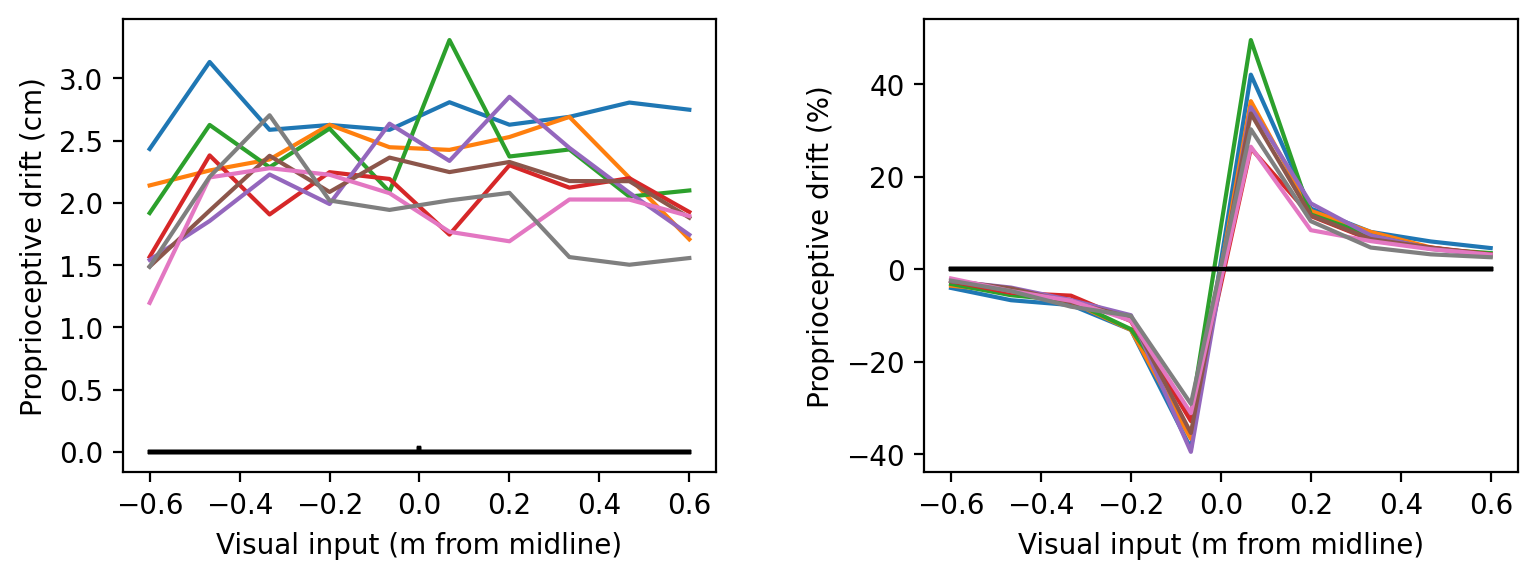

In [11]:
## proprioceptive drift
nPos=10
nRep=500
ntrials=nPos*nRep
nsteps=1
NV=g.NV
pBcs=np.zeros((ntrials,2))
pHs=np.zeros((ntrials,1))
pHcs=np.zeros((ntrials,2))
Ts=np.zeros((ntrials,1))
rBcs=np.zeros((g.NV[0],ntrials))
rHs=np.zeros((g.NV[1],ntrials))

positions=np.linspace(g.NeuronInfo[0].min[0],g.NeuronInfo[0].max[0],nPos)
tStrengths=np.concatenate((0,np.arange(4,10+1)),axis=None)
maxPDs=np.zeros(np.size(tStrengths))
#colours=[0,0,0;jet( np.size(tStrengths-1) )]
tFlag=Ts
pH=[0,0.25]

plt.figure(4)
fig, axs = plt.subplots(1, 2, figsize=(9, 3),dpi = 200)

for ts in np.arange(np.size(tStrengths)):
    tStrength=tStrengths[ts]
    count=0
    for p in np.arange(nPos):
        stims=np.zeros((np.sum(g.NV),nRep)) #again stimuli are noiseless since we only care about averages here
        for r in np.arange(nRep):
            count=count+1
            y=.6*np.random.rand()
            pBc=np.array([positions[p],y])
            pH=np.array([0,y])
            gains=4+6*np.random.rand(3,1)
            Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
            T=tStrength+0*T
            stims[:,r]=np.concatenate((Bc, H, T), axis=None)
            pBcs[count-1,:]=pBc
            pHs[count-1]=pH[0]
            pHcs[count-1,:]=pBc-pH
        
        for s in np.arange(nsteps):
            h,mymu=g.fastUp(stims)
            v,mymu=g.fastDown(h)
            stims[g.NV[0]:g.NV[0]+g.NV[1],:]=v[g.NV[0]:g.NV[0]+g.NV[1],:]
        cols=np.arange(nRep)+(p)*nRep
        rHs[:,cols]=v[g.NV[0]:g.NV[0]+g.NV[1],:]
        rBcs[:,cols]=v[0:g.NV[0],:]
    

    touchedH=np.zeros((g.NV[1],nPos))
    nTouchedH=touchedH
    touchedBc=np.zeros((g.NV[0],nPos))
    nTouchedBc=touchedBc
    m=np.ceil(np.sqrt(nPos))
    n=np.round(nPos/m)
    tp=np.zeros((nRep,nPos))
    ntp=[]
    wx,wy=np.meshgrid(np.arange(g.NeuronInfo[1].n[0],dtype=float),np.arange(g.NeuronInfo[1].n[1],dtype=float))
    
    for p in np.arange(nPos):
        cols=np.arange(nRep)+(p)*nRep
        touchedH[:,p]=np.nanmean(rHs[:,cols],1)
        touchedBc[:,p]=np.mean(rBcs[:,cols],1)
        hCurr=rHs[:,cols]
        
        for i in np.arange(np.shape(hCurr)[1]):
            w=np.flipud(np.rot90(np.reshape(hCurr[:,i],g.NeuronInfo[1].n)))
            barX=np.sum(np.sum(np.multiply(w,wx)))/np.sum(w[:])
            barY=np.sum(np.sum(np.multiply(w,wy)))/np.sum(w[:])
            tp[i,p]=barX
        
    ax1=plt.subplot(121)
    err=g.NeuronInfo[1].span[0]*np.nanstd(tp)/(g.NeuronInfo[1].n[0]*np.sqrt(np.shape(tp)[0]))
    y=indToPos(np.array([np.nanmean(tp,axis=0),0*np.nanmean(tp,axis=0)]).T,g.NeuronInfo[1]) #double check the output of indToPos. 
    y=y[:,0].T
    maxPDs[ts]=np.max(y)
    ax1.plot(positions, 100*y) #, 'LineWidth',2,'color',colours(ts,:));
    ax1.plot(positions,np.zeros(np.shape(positions)),'k')    #'--','LineWidth',2,'color','k')
    ax1.plot([0,0],[np.min(y),np.max(y)],'k') #,'--','LineWidth',2,'color','k')
    ax1.set_xlabel('Visual input (m from midline)')
    ax1.set_ylabel('Proprioceptive drift (cm)')
    
    ax2=plt.subplot(122)
    err=g.NeuronInfo[1].span[0]*np.nanstd(tp)/(g.NeuronInfo[1].n[0]*np.sqrt(np.shape(tp)[0]))
    y=indToPos(np.array([np.nanmean(tp,axis=0),0*np.nanmean(tp,axis=0)]).T,g.NeuronInfo[1])
    y=y[:,0].T
    ax2.plot(positions,100*(y/positions)) # ,'LineWidth',2,'color',colours(ts,:));
    ax2.plot(positions,np.zeros(np.shape(positions)),'k') #'--','LineWidth',2,'color','k')
    ax2.plot([0,0],[np.min(y),np.max(y)],'k') #'--','LineWidth',2,'color','k')
    ax2.set_xlabel('Visual input (m from midline)')
    ax2.set_ylabel('Proprioceptive drift (%)')
    
fig.subplots_adjust(wspace=0.35)      
plt.show()

In [12]:
""" import pickle
with open('trained.pkl', 'wb') as output:
    pickle.dump(g, output, pickle.HIGHEST_PROTOCOL) """

" import pickle\nwith open('trained.pkl', 'wb') as output:\n    pickle.dump(g, output, pickle.HIGHEST_PROTOCOL) "